# Assignment 4

## Purpose:
1) To understand how linear discrimination and neural networks work.
2) To understand AdaBoost algorithm and classifier diversity

## About Data:
Dataset from: https://archive.ics.uci.edu/ml/machine-learning-databases/optdigits/

test set: optdigits.tes
training set: optdigits.tra

NOTE: For this homework, use only classes 6 and 9. Delete all the other classes from the original training and test datasets. Rename class 6 as “0” and class 9 as “1” so that your algorithms work.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
import io
from math import exp

In [2]:
# Load data from required files
def load_data(filename):
    with open(filename, "r") as file:
        data_string = file.read()
    data = io.StringIO(data_string)
    colnames = [i for i in range(1,66)]
    df = pd.read_csv(data, index_col=False, names=colnames, sep=",")
    return df

In [3]:
# Create training datasets 
train_df = load_data("optdigits.tra")
train_df = train_df[train_df[65].isin([6,9])]
train_df[65] = train_df[65].map({6:0,9:1})

In [4]:
# Create testing datasets
test_df = load_data("optdigits.tes")
test_df = test_df[test_df[65].isin([6,9])]
test_df[65] = test_df[65].map({6:0,9:1})

### Q1 [6pts]: Implement the logistic regression (i.e. 1 layer neural network with a single sigmoidal output) algorithm yourself in Python, use adaptive learning rate and momentum for training. Train and test 10 times, each time, start from different random initial weights and use a random subset of 80% of the training data and also start with a different initial learning rate (e.g. 0.0001, 0.005, 0.001, 0.01 etc.) and momentum (0.9, 0.95, 0.99). Report the total training and test errors for each of the 10 runs. Report also the initial learning rate and the momentum you used. 

In [5]:
# Function to return sigmoid of the scores
def sigmoid(scores):
    return 1 / (1 + np.exp(-scores))

In [6]:
# Function to create training set (80% data) and validation set (20% data)
def create_train_validation_data(train_df):
    train_set = train_df.sample(frac=0.8)
    validation_set = train_df.loc[~train_df.index.isin(train_set.index)]
    return train_set.loc[:,1:64], train_set[65], validation_set.loc[:,1:64], validation_set[65]

In [7]:
# Function to calculate mean squared error
def mean_squared_error(y_pred, y_actual):
    return np.square(np.subtract(y_actual, y_pred)).mean() 

In [8]:
# Function to calculate error
def error(y_pred, y_actual):
    return 1 - (y_pred == y_actual).sum().astype(float) / len(y_actual)

In [9]:
# Function to plot number of epochs v/s training/validation error to find epochs required for the model to converge
def plot_epoch_vs_error(epochs, train_error_list, validation_error_list):
    epoch_list = list(range(1, epochs+1))
    p1, = plt.plot(epoch_list, train_error_list, marker='o', markerfacecolor='r', markersize=6, color='r', linewidth=2)
    p2, = plt.plot(epoch_list, validation_error_list, marker='o', markerfacecolor='b', markersize=4, color='b', linewidth=1)
    plt.xlabel('Number of epochs')
    plt.ylabel('Mean Squared Error')
    plt.title('Epochs v/s Mean Squared Error')
    plt.legend([p1,p2], ["train-error", "validation-error"])

In [10]:
# Function to create logistic regression model 
# uses 80% of the training data and uses 20% for validation
# initializes weights to random values for each feature each time
# uses learning rate and momentum for faster convergence

def logistic_regression(train_df, epochs, learning_rate, momentum, plot_error=False):
    
    # create training set (80% data) and validation set (20% data)
    train_features, train_target, validation_features, validation_target = create_train_validation_data(train_df)
    
    # initialize weights randomly
    weights = np.random.uniform(low=-0.01, high=0.01, size=train_features.shape[1])
    
    train_error_list, validation_error_list = [], []
    # parameters to update learning rate
    a = 0.00001
    b = 0.01
    
    # Run epochs and use gradient descent algorithm to converge 
    for step in range(1, epochs+1):
        
        scores = np.dot(train_features, weights)
        predictions = sigmoid(scores)
        
        # calculate train error
        train_predictions = np.round(predictions)
        train_error = mean_squared_error(train_predictions, train_target)
        train_error_list.append(train_error)
        if(step == 1):
            prev_train_error = train_error
        
        # calculate validation error
        validation_pred = np.round(sigmoid(np.dot(validation_features, weights)))
        validation_error = mean_squared_error(validation_pred, validation_target)
        validation_error_list.append(validation_error)
        
        #update learning rate
        if(step%10 == 0):    
            if(prev_train_error < train_error):
                learning_rate += a
            else:
                learning_rate -= b*learning_rate
            prev_train_error = train_error
            
        # Update weights with gradient
        train_error_signal = train_target - predictions
        gradient = np.dot(train_features.T, train_error_signal)
        weights = momentum * weights + learning_rate * gradient

    # plot number of epochs v/s training and validation errors
    if plot_error == True:
        plot_epoch_vs_error(epochs, train_error_list, validation_error_list)
    
    return weights, train_features, train_target, validation_features, validation_target

### Investigate number of epochs required

#### Case 1: 10 epochs

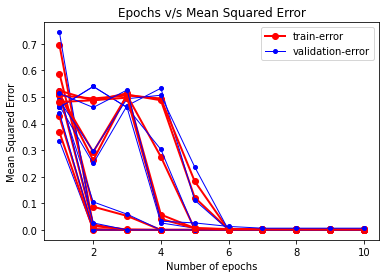

In [11]:
for num_run in range(10):
    weights, train_X, train_y, val_X, val_y = logistic_regression(train_df, 10, 0.0001, momentum=0.95, plot_error=True)

#### Case 2: 50 epochs

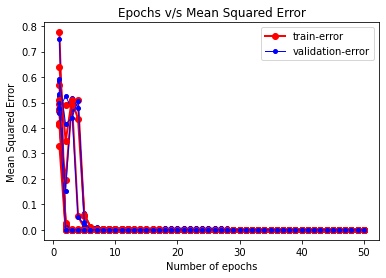

In [12]:
for num_run in range(10):
    weights, train_X, train_y, val_X, val_y = logistic_regression(train_df, 50, 0.0001, momentum=0.95, plot_error=True)

#### Case 3: 100 epochs

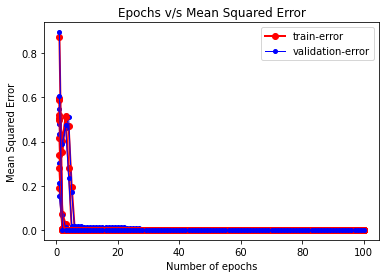

In [13]:
for num_run in range(10):
    weights, train_X, train_y, val_X, val_y = logistic_regression(train_df, 100, 0.0001, momentum=0.95, plot_error=True)

For all 10 runs in each case above, we observe that after 30 epochs, we have reached a global minima, hence for our model we run 30 epochs 

 ### Initial Learning rate = 0.0001, Momentum = 0.95 and Number of epochs = 30

In [14]:
run_df = pd.DataFrame(columns = ["Run Number", "Train Error", "Validation Error", "Test Error"])
ten_runs_test_error = []
ten_runs_weights = []
for num_run in range(10): 
    weights, train_X, train_y, val_X, val_y = logistic_regression(train_df, epochs=30, learning_rate=0.0001, momentum=0.95)
    ten_runs_weights.append(weights)
    
    # calculate training error
    train_pred = np.round(sigmoid(np.dot(train_X, weights)))
    train_error = error(train_pred, train_y)
    
    #calculate validation error
    validation_pred = np.round(sigmoid(np.dot(val_X, weights)))
    validation_error = error(validation_pred, val_y)
    
    #calculate test error
    test_pred = np.round(sigmoid(np.dot(test_df.loc[:,1:64], weights)))
    test_error = error(test_pred, test_df[65])
    ten_runs_test_error.append(test_error)
    
    run_df.loc[num_run] = [num_run + 1, train_error, validation_error, test_error]
print(run_df)

   Run Number  Train Error  Validation Error  Test Error
0         1.0          0.0               0.0     0.00277
1         2.0          0.0               0.0     0.00000
2         3.0          0.0               0.0     0.00000
3         4.0          0.0               0.0     0.00000
4         5.0          0.0               0.0     0.00000
5         6.0          0.0               0.0     0.00000
6         7.0          0.0               0.0     0.00000
7         8.0          0.0               0.0     0.00000
8         9.0          0.0               0.0     0.00000
9        10.0          0.0               0.0     0.00000


### Q2 [2.5pts]: Using the 10 runs in Q1, for each feature compute feature importance as a) Fa: the average (over 10 runs) increase in the test error when the weight for that feature is set to 0. For each feature, compute also, b) Fb: the variance of each feature on the test set and c) Fc: the mutual information between the feature column and the label column. Plot x=Fa and y=Fb, Fc. Comment on how your feature importance Fa the other measurements Fb and Fc are related.

In [15]:
# Function to compute Fa, Fb and Fc
# Fa: the average (over 10 runs) increase in the test error when the weight for that feature is set to 0
# Fb: the variance of each feature on the test set
# Fc: the mutual information between the feature column and the label column

def compute_fa_fb_fc(ten_runs_test_error, ten_runs_weights):
    avg_test_error = np.mean(ten_runs_test_error)
    new_ten_runs_test_error = []
    Fa, Fb, Fc = [], [], []
    for feature in list(train_df.columns)[:-1]:
        for i in range(10):
            ten_runs_weights[i][feature-1] = 0
            test_pred = np.round(sigmoid(np.dot(test_df.loc[:,1:64], ten_runs_weights[i])))
            test_error = error(test_pred, test_df[65])
            new_ten_runs_test_error.append(test_error)
        avg_test_error_new = np.mean(new_ten_runs_test_error)
        Fa.append(avg_test_error_new - avg_test_error)
        Fb.append(np.std(test_df[feature])**2)
        Fc.append(metrics.mutual_info_score(test_df[feature], test_df[65]))
    return Fa, Fb, Fc

In [16]:
Fa, Fb, Fc = compute_fa_fb_fc(ten_runs_test_error, ten_runs_weights)

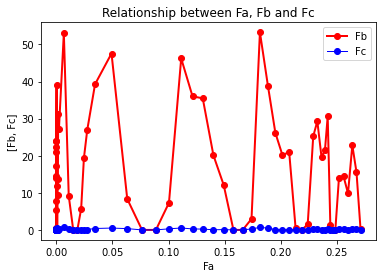

In [17]:
plt.plot(Fa, Fb, label = 'Fb', marker='o', markerfacecolor='r', markersize=6, color='r', linewidth=2)
plt.plot(Fa, Fc, label = 'Fc', marker='o', markerfacecolor='b', markersize=6, color='b', linewidth=1)
plt.xlabel('Fa')
plt.ylabel('[Fb, Fc]')
plt.title('Relationship between Fa, Fb and Fc')
plt.legend()

Text(0.5, 1.0, 'Relationship between Fa, Fc')

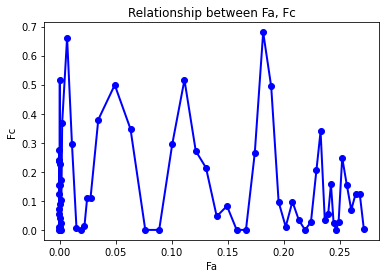

In [18]:
plt.plot(Fa, Fc, marker='o', markerfacecolor='b', markersize=6, color='b', linewidth=2)
plt.xlabel('Fa')
plt.ylabel('Fc')
plt.title('Relationship between Fa, Fc')

We observe that relationship between Fa and Fb, i.e variance of the features does not tell much but just that a lot of features do not contribute much to predict the target because the increase in test error is very low (around 0.0).That is on x-axis, we see a lot of features near Fa=~0.0

We also observe that Fc is almost a straight line wrt Fa. However by looking closely, we find that it is not a straight line but has small peaks. Fc varies in the range of about 0 to 0.7 when plotted against Fa. It means that the average increase in the test error by putting 0 weight for some features, and the mutual information between features and target is very high for some features while for others it is very low, i.e. they are not important to predict the target.

### Q3 [4pts]: Use the scikit-learn neural network implementation to train a neural network and test it using the same instances as in Q1. Decrease the test error as much as you can through selection of: 1) different number of hidden layers and units, 2) L1 or L2 regularization/weight decay, 3) different optimization algorithms, 4) feature selection

In [19]:
# split train and test features and target
train_X, train_y = train_df.loc[:, 1:64], train_df[65]
test_X, test_y = test_df.loc[:, 1:64], test_df[65]

In [20]:
# Data Preprocessing: Neural network may have difficulty converging before max iterations allowed if data is not normalized.
scaler = StandardScaler()
# Fit Standard scalar to the training data
scaler.fit(train_X)
# Now apply the transformations to the training and test data
train_X = scaler.transform(train_X)
test_X = scaler.transform(test_X)

In [21]:
 # select important features with Feature Selection from sklearn library
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(train_X, train_y)
model = SelectFromModel(lsvc, prefit=True)

In [22]:
# transform features of train and test data to keep only the most important features
train_X_new = model.transform(train_X)
test_X_new = model.transform(test_X)

In [23]:
print("Training data features new shape:", train_X_new.shape)
print("Testing data features new shape:", test_X_new.shape)

Training data features new shape: (759, 4)
Testing data features new shape: (361, 4)


#### Multilayer Perceptron classifier
 1. hidden_layer_sizes denotes a tuple, where the ith element represents the number of neurons in the ith hidden layer.
 2. max_iter denotes the number of epochs the model will run until convergence.
 3. alpha denotes L2 penalty (regularization term) parameter.

#### Try 1

In [24]:
mlp_classifier = MLPClassifier(hidden_layer_sizes=(2,2,2), max_iter=300, alpha=0.0001)
mlp_classifier.fit(train_X_new, train_y)

MLPClassifier(hidden_layer_sizes=(2, 2, 2), max_iter=300)

In [25]:
predict_train = mlp_classifier.predict(train_X_new)
predict_test = mlp_classifier.predict(test_X_new)

In [26]:
train_error = 1 - mlp_classifier.score(train_X_new, train_y)
test_error = 1 - mlp_classifier.score(test_X_new, test_y)

In [27]:
print(train_error)
print(test_error)

0.5032938076416338
0.4986149584487535


#### Try 2

In [28]:
mlp_classifier = MLPClassifier(hidden_layer_sizes=(2,2,2), max_iter=400, alpha=0.0001)
mlp_classifier.fit(train_X_new, train_y)

C:\Users\batul\AppData\Roaming\Python\Python38\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(2, 2, 2), max_iter=400)

In [29]:
predict_train = mlp_classifier.predict(train_X_new)
predict_test = mlp_classifier.predict(test_X_new)

In [30]:
train_error = 1 - mlp_classifier.score(train_X_new, train_y)
test_error = 1 - mlp_classifier.score(test_X_new, test_y)

In [31]:
print(train_error)
print(test_error)

0.0
0.0027700831024930483


#### Try 3

In [32]:
mlp_classifier = MLPClassifier(hidden_layer_sizes=(3,3,3), max_iter=400, alpha=0.0001)
mlp_classifier.fit(train_X_new, train_y)

C:\Users\batul\AppData\Roaming\Python\Python38\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(3, 3, 3), max_iter=400)

In [33]:
predict_train = mlp_classifier.predict(train_X_new)
predict_test = mlp_classifier.predict(test_X_new)

In [34]:
train_error = 1 - mlp_classifier.score(train_X_new, train_y)
test_error = 1 - mlp_classifier.score(test_X_new, test_y)

In [35]:
print(train_error)
print(test_error)

0.0
0.0


#### Try 4

In [36]:
mlp_classifier = MLPClassifier(hidden_layer_sizes=(4,4,4), max_iter=400, alpha=0.001)
mlp_classifier.fit(train_X_new, train_y)

MLPClassifier(alpha=0.001, hidden_layer_sizes=(4, 4, 4), max_iter=400)

In [37]:
predict_train = mlp_classifier.predict(train_X_new)
predict_test = mlp_classifier.predict(test_X_new)

In [38]:
train_error = 1 - mlp_classifier.score(train_X_new, train_y)
test_error = 1 - mlp_classifier.score(test_X_new, test_y)

In [39]:
print("Train error:", train_error)
print("Test error:", test_error)

Train error: 0.0
Test error: 0.0


Hence with a sklearn neural network, we observe that we have a test error 0 with only 4 important features when we preprocess the data by normalizing with StandardScalar in the sklearn preprocessing library. We used 4 hidden layer neural network with maximum iterations = 400 and L2 regularization parameter alpha = 0.0001 and the model converged and training and test error becomes 0.0 